In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

In [ ]:
##Transaction details file of customers
td_df=pd.read_csv("/content/drive/My Drive/FinalProject/transaction_details_data.csv")
td_df.head()

,transaction_id,amount_usd,transactions_type,transactions_state,user_id,created_date
0,tx_0,4.55,TRANSFER,COMPLETED,c_898,2018-04-03 03:34:21.784487
1,tx_1,15.50,CARD_PAYMENT,COMPLETED,c_1652,2019-03-19 06:15:59.537032
2,tx_2,43.40,CARD_PAYMENT,COMPLETED,c_1652,2019-03-18 18:53:41.323032
3,tx_3,10043.01,TRANSFER,COMPLETED,c_1652,2019-03-22 14:20:01.513032
4,tx_4,43.81,CARD_PAYMENT,COMPLETED,c_5509,2019-03-22 05:42:50.316652


In [ ]:
##Checking on the info 
td_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740075 entries, 0 to 2740074
Data columns (total 6 columns):
 #   Column              Dtype  
---  ------              -----  
 0   transaction_id      object 
 1   amount_usd          float64
 2   transactions_type   object 
 3   transactions_state  object 
 4   user_id             object 
 5   created_date        object 
dtypes: float64(1), object(5)
memory usage: 125.4+ MB


In [ ]:
print("Shape of Transaction details file is :",td_df.shape)
print("The total count of missing field in this dataset is :",td_df.isnull().sum().sum())

Shape of Transaction details file is : (2740075, 6)
The total count of missing field in this dataset is : 0


In [ ]:
##Different state of transaction with their proportion.
td_df['transactions_state'].value_counts()

COMPLETED    2407968
DECLINED      155286
REVERTED      112618
FAILED         41053
PENDING        21492
CANCELLED       1658
Name: transactions_state, dtype: int64

In [ ]:
##As the data is highly imbalanced so we'll keep our focus on the completed transaction to identify unengaed customer.
completed_df=td_df.loc[td_df['transactions_state']=='COMPLETED']
completed_df.shape

(2407968, 6)

In [ ]:
##Modifying the column as per the need.
##1. Converting Date column datatype from objet to datetime
completed_df['created_date']=pd.to_datetime(completed_df['created_date'])
##2. Extracting Day
completed_df['day']=completed_df['created_date'].dt.day
##3. Extracting Month
completed_df['month']=completed_df['created_date'].dt.month
##4. Extracting Year
completed_df['year']=completed_df['created_date'].dt.year
##5. Extracting YearMonth
completed_df['yearmonth']=completed_df.apply(lambda completed_df: str(completed_df['year'])+"_"+str(completed_df['month']),axis=1)

##view 
completed_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,transaction_id,amount_usd,transactions_type,transactions_state,user_id,created_date,day,month,year,yearmonth
0,tx_0,4.55,TRANSFER,COMPLETED,c_898,2018-04-03 03:34:21.784487,3,4,2018,2018_4
1,tx_1,15.50,CARD_PAYMENT,COMPLETED,c_1652,2019-03-19 06:15:59.537032,19,3,2019,2019_3
2,tx_2,43.40,CARD_PAYMENT,COMPLETED,c_1652,2019-03-18 18:53:41.323032,18,3,2019,2019_3
3,tx_3,10043.01,TRANSFER,COMPLETED,c_1652,2019-03-22 14:20:01.513032,22,3,2019,2019_3
4,tx_4,43.81,CARD_PAYMENT,COMPLETED,c_5509,2019-03-22 05:42:50.316652,22,3,2019,2019_3


In [ ]:
##Evaluating
completed_df.describe()

,amount_usd,day,month,year
count,2407968.00,2407968.00,2407968.00,2407968.00
mean,64.44,15.49,5.91,2018.49
std,864.84,8.89,3.70,0.50
min,0.00,1.00,1.00,2018.00
25%,2.42,8.00,3.00,2018.00
50%,8.51,15.00,5.00,2018.00
75%,28.28,23.00,10.00,2019.00
max,612766.46,31.00,12.00,2019.00


In [ ]:
##Checking the proportion of the year
completed_df['year'].value_counts()

2018    1220913
2019    1187055
Name: year, dtype: int64

In [ ]:
##one record per customer per year month
##Total transaction for each user_id per year month
total_trans=pd.DataFrame(completed_df.groupby(['user_id','yearmonth'])['amount_usd'].count()).rename(columns={'amount_usd':'No_of_transaction'})
total_trans.head()

No_of_transaction
user_id yearmonth                   
c_0     2018_1                    15
        2018_10                   24
        2018_11                   10
        2018_12                    9
        2018_2                    13

In [ ]:
total_trans.head()

No_of_transaction
user_id yearmonth                   
c_0     2018_1                    15
        2018_10                   24
        2018_11                   10
        2018_12                    9
        2018_2                    13

In [ ]:
##Total amount spend for each user_id
total_usd=pd.DataFrame(completed_df.groupby(['user_id','yearmonth'])['amount_usd'].sum()).rename(columns={'amount_usd':'Total_USD'})
total_usd.head()

Total_USD
user_id yearmonth           
c_0     2018_1        184.99
        2018_10       578.88
        2018_11       122.37
        2018_12        96.21
        2018_2        871.05

In [ ]:
##Total distinct type of transaction for each user_id
distinct_trans=pd.DataFrame(completed_df.groupby(['user_id','yearmonth'])['transactions_type'].nunique()).rename(columns={'transactions_type':'Distinct_Trans_Count'})
distinct_trans.head()

Distinct_Trans_Count
user_id yearmonth                      
c_0     2018_1                        4
        2018_10                       5
        2018_11                       4
        2018_12                       3
        2018_2                        4

In [ ]:
##Total distinct days of transactions for each user_id
distinct_days=pd.DataFrame(completed_df.groupby(['user_id','yearmonth'])['day'].nunique()).rename(columns={'day':'Distinct_Days_Count'})
distinct_days.head()

Distinct_Days_Count
user_id yearmonth                     
c_0     2018_1                       4
        2018_10                      9
        2018_11                      6
        2018_12                      6
        2018_2                       6

In [ ]:
print(total_trans.shape,total_usd.shape,distinct_trans.shape,distinct_days.shape)

(119936, 1) (119936, 1) (119936, 1) (119936, 1)


In [ ]:
##Combine dataframe all together ["total_trans","total_usd","distinct_trans","distinct_days"]
join1=total_trans.join(total_usd)
join2=join1.join(distinct_trans)
join3=join2.join(distinct_days)
join3.head()

No_of_transaction  ...  Distinct_Days_Count
user_id yearmonth                     ...                     
c_0     2018_1                    15  ...                    4
        2018_10                   24  ...                    9
        2018_11                   10  ...                    6
        2018_12                    9  ...                    6
        2018_2                    13  ...                    6

[5 rows x 4 columns]

In [ ]:
print(join3.shape)

(119936, 4)


In [ ]:
join3.describe()

,No_of_transaction,Total_USD,Distinct_Trans_Count,Distinct_Days_Count
count,119936.00,119936.00,119936.00,119936.00
mean,20.08,1293.86,2.77,6.98
std,32.65,9950.77,1.36,6.97
min,1.00,0.00,1.00,1.00
25%,3.00,43.40,2.00,2.00
50%,8.00,283.41,3.00,4.00
75%,24.00,1024.65,4.00,10.00
max,855.00,1861358.14,9.00,31.00


In [ ]:
##Scale the data
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
scaled_mmx_df=pd.DataFrame((ss.fit_transform(join3)),columns=join3.columns)
scaled_mmx_df.head()

,No_of_transaction,Total_USD,Distinct_Trans_Count,Distinct_Days_Count
0,-0.16,-0.11,0.91,-0.43
1,0.12,-0.07,1.64,0.29
2,-0.31,-0.12,0.91,-0.14
3,-0.34,-0.12,0.17,-0.14
4,-0.22,-0.04,0.91,-0.14


In [ ]:
scaled_mmx_df.describe()

,No_of_transaction,Total_USD,Distinct_Trans_Count,Distinct_Days_Count
count,119936.00,119936.00,119936.00,119936.00
mean,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-0.58,-0.13,-1.30,-0.86
25%,-0.52,-0.13,-0.57,-0.71
50%,-0.37,-0.10,0.17,-0.43
75%,0.12,-0.03,0.91,0.43
max,25.57,186.93,4.59,3.44


In [ ]:
##Build Cluster to predict class of engagged vs unengagged user
##Kmeans


wcc_list=[]
for i in range(1,20):
  km=KMeans(i,init='k-means++',random_state=10)
  km.fit(scaled_mmx_df)
  wcc_list.append(km.inertia_)


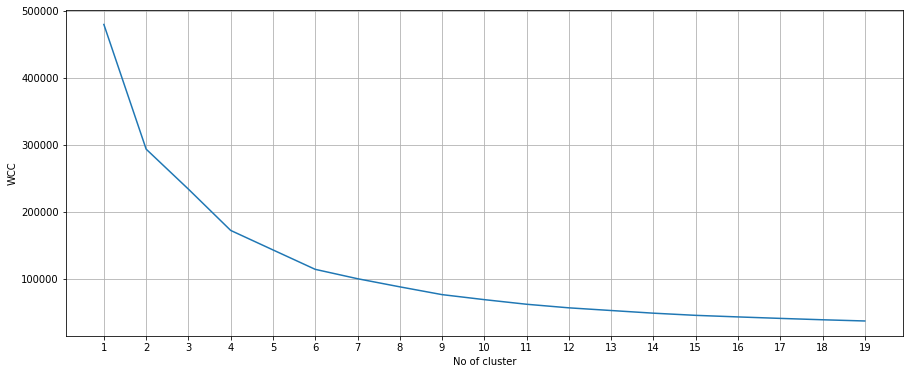

In [ ]:
##Plot Elbow graph

plt.figure(figsize=(15,6))
plt.plot(range(1,20),wcc_list)
plt.xlabel("No of cluster")
plt.ylabel("WCC")
plt.xticks(range(1,20))
plt.grid(True)
plt.show()

In [ ]:
##Making 2 cluster
km2=KMeans(n_clusters=2,init='k-means++',random_state=10)
km2.fit(scaled_mmx_df)
y_pred=km2.predict(scaled_mmx_df)
print("WCSS :",km2.inertia_)
print("Cluster centers",km2.cluster_centers_)

WCSS : 293728.3805521355
Cluster centers [[ 1.25389747  0.23000806  1.12973666  1.48789073]
 [-0.38018032 -0.06973819 -0.3425349  -0.45112681]]


In [ ]:
##Store the result
partech_clus=join3.reset_index()
partech_clus['Kmeans_Cluster']=y_pred
partech_clus.to_csv("/content/drive/My Drive/FinalProject/partech_clus.csv")
partech_clus.head()

,user_id,yearmonth,No_of_transaction,Total_USD,Distinct_Trans_Count,Distinct_Days_Count,Kmeans_Cluster
0,c_0,2018_1,15,184.99,4,4,1
1,c_0,2018_10,24,578.88,5,9,0
2,c_0,2018_11,10,122.37,4,6,1
3,c_0,2018_12,9,96.21,3,6,1
4,c_0,2018_2,13,871.05,4,6,1


In [ ]:
##Resetting the index to retrieve user_id as a column
join4=join3.reset_index()
##Create a copy of scaled_mmx_df and create a new column 'user_id'
new_scaled_mmx_df=scaled_mmx_df.copy()
new_scaled_mmx_df['user_id']=join4['user_id']
new_scaled_mmx_df['yearmonth']=join4['yearmonth']
new_scaled_mmx_df['year']=join4['yearmonth'].apply(lambda ym: ym[0:4])
##Adding a new column with KMeans cluster predictions on existing dataset
new_scaled_mmx_df['Kmeans_Cluster']=y_pred
new_scaled_mmx_df.head()

,No_of_transaction,Total_USD,Distinct_Trans_Count,Distinct_Days_Count,user_id,yearmonth,year,Kmeans_Cluster
0,-0.16,-0.11,0.91,-0.43,c_0,2018_1,2018,1
1,0.12,-0.07,1.64,0.29,c_0,2018_10,2018,0
2,-0.31,-0.12,0.91,-0.14,c_0,2018_11,2018,1
3,-0.34,-0.12,0.17,-0.14,c_0,2018_12,2018,1
4,-0.22,-0.04,0.91,-0.14,c_0,2018_2,2018,1


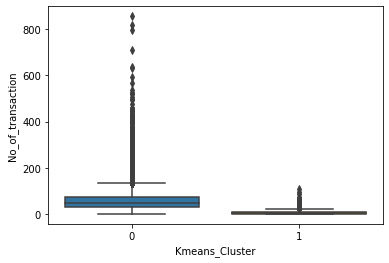

In [ ]:
##visualize no_of_trans
sns.boxplot(x='Kmeans_Cluster', y='No_of_transaction', data=partech_clus)

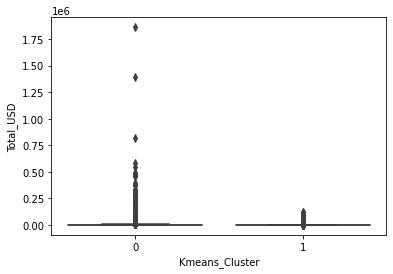

In [ ]:
##visualize total_usd
sns.boxplot(x='Kmeans_Cluster', y='Total_USD', data=partech_clus)

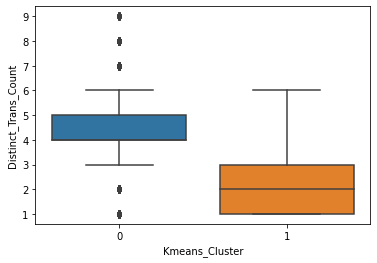

In [ ]:
##visualize Distinct_Trans_Count
sns.boxplot(x='Kmeans_Cluster', y='Distinct_Trans_Count', data=partech_clus)

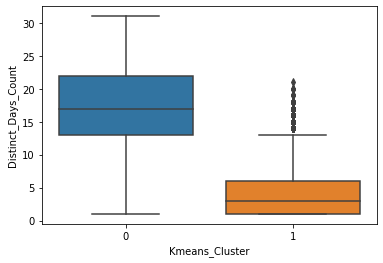

In [ ]:
##visualize Distinct_Days_Count
sns.boxplot(x='Kmeans_Cluster', y='Distinct_Days_Count', data=partech_clus)

We can classify 1 as unengagged users and 0 as more engagged users.

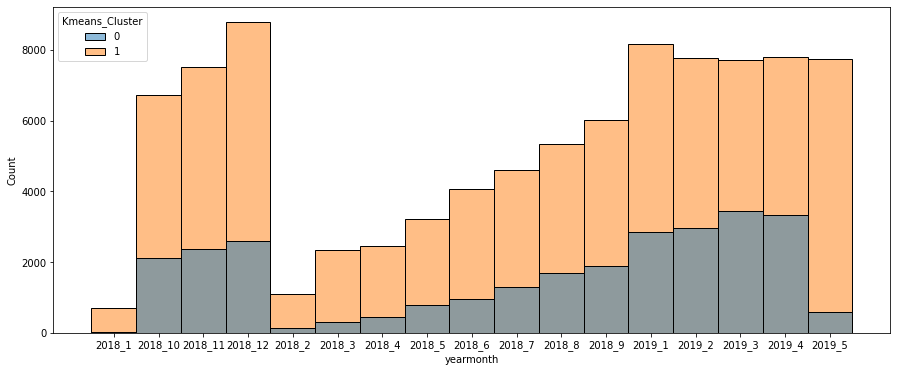

In [ ]:
##The distribution of the target across the yearmonth
import seaborn as sns
plt.figure(figsize=(15,6))
sns.histplot(data=new_scaled_mmx_df,x='yearmonth',hue='Kmeans_Cluster')


The class of engagged and unengagged user is not distributed across the yearmonth uniformly. The target class is imbalanced.

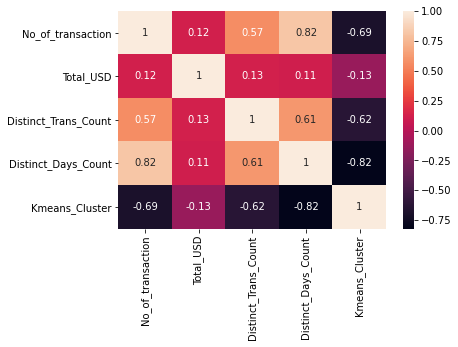

In [ ]:
##correlation

sns.heatmap(new_scaled_mmx_df.corr(),annot=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# the independent variables set 
XX = new_scaled_mmx_df.drop(['user_id','yearmonth','year','Kmeans_Cluster'],axis=1)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = XX.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(XX.values, i) 
                          for i in range(len(XX.columns))] 
  
print(vif_data)

                feature  VIF
0     No_of_transaction 3.09
1             Total_USD 1.02
2  Distinct_Trans_Count 1.65
3   Distinct_Days_Count 3.37


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




*   Distinct_Days_Count has high V.I.F and highly correlated with no of transaction and distinct transaction count.




In [ ]:
##Dropping Distinct_Days_Count
new_scaled_mmx_df=new_scaled_mmx_df.drop(['Distinct_Days_Count'],axis=1)
new_scaled_mmx_df.head()

,No_of_transaction,Total_USD,Distinct_Trans_Count,user_id,yearmonth,year,Kmeans_Cluster
0,-0.16,-0.11,0.91,c_0,2018_1,2018,1
1,0.12,-0.07,1.64,c_0,2018_10,2018,0
2,-0.31,-0.12,0.91,c_0,2018_11,2018,1
3,-0.34,-0.12,0.17,c_0,2018_12,2018,1
4,-0.22,-0.04,0.91,c_0,2018_2,2018,1


In [ ]:
##Will train, evaluate the model on the 2018's data, and test it on 2019's data
completed_2018=new_scaled_mmx_df.loc[new_scaled_mmx_df['year']=='2018']
completed_2019=new_scaled_mmx_df.loc[new_scaled_mmx_df['year']=='2019']

In [ ]:
##Split the data such that:
##Training data - 80% till 201809
##Validation data 1 (out-of-sample) - 20% till 201809
data_till_201809=completed_2018.loc[~((completed_2018['yearmonth']=='2018_10') | (completed_2018['yearmonth']=='2018_11') | (completed_2018['yearmonth']=='2018_12'))]
data_till_201809=data_till_201809.reset_index()
data_till_201809=data_till_201809.drop('index',axis=1)
data_till_201809.yearmonth.value_counts()

2018_9    7903
2018_8    7028
2018_7    5891
2018_6    5025
2018_5    4022
2018_4    2922
2018_3    2654
2018_2    1246
2018_1     746
Name: yearmonth, dtype: int64

In [ ]:
data_till_201809.head()

,No_of_transaction,Total_USD,Distinct_Trans_Count,user_id,yearmonth,year,Kmeans_Cluster
0,-0.16,-0.11,0.91,c_0,2018_1,2018,1
1,-0.22,-0.04,0.91,c_0,2018_2,2018,1
2,0.64,-0.02,1.64,c_0,2018_3,2018,0
3,-0.25,0.01,0.17,c_0,2018_4,2018,1
4,-0.06,-0.11,0.17,c_0,2018_5,2018,1


In [ ]:
##X and Y
X=completed_2018.drop(['Kmeans_Cluster','year','yearmonth','user_id'],axis=1)
Y=completed_2018['Kmeans_Cluster']

In [ ]:
print(X.shape)

(67533, 3)


In [ ]:
X.head()

,No_of_transaction,Total_USD,Distinct_Trans_Count
0,-0.16,-0.11,0.91
1,0.12,-0.07,1.64
2,-0.31,-0.12,0.91
3,-0.34,-0.12,0.17
4,-0.22,-0.04,0.91


In [ ]:
Y.head()

0    1
1    0
2    1
3    1
4    1
Name: Kmeans_Cluster, dtype: int32

In [ ]:
##Train Test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,stratify=Y,random_state=101)
print(x_train.shape,x_test.shape)

(54026, 3) (13507, 3)


**Train, tune and validate an XGBoost,Logistic Regression**

****XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)****


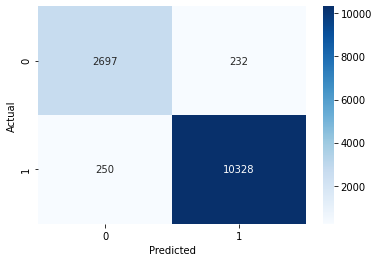

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2929
           1       0.98      0.98      0.98     10578

    accuracy                           0.96     13507
   macro avg       0.95      0.95      0.95     13507
weighted avg       0.96      0.96      0.96     13507

****LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)****


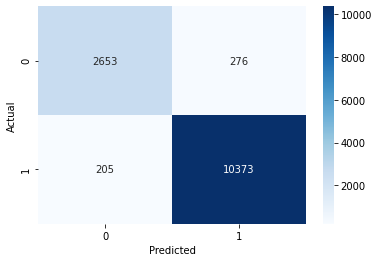

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2929
           1       0.97      0.98      0.98     10578

    accuracy                           0.96     13507
   macro avg       0.95      0.94      0.95     13507
weighted avg       0.96      0.96      0.96     13507



In [ ]:
##Validation1
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

models=[XGBClassifier(),LogisticRegression()]
for i in models:
  print("****{}****".format(i))
  i.fit(x_train,y_train)
  pred=i.predict(x_test)
  cnf_matrix=confusion_matrix(y_test,pred)
  sns.heatmap(cnf_matrix,annot=True, fmt='', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  print(classification_report(y_test,pred))

In [ ]:
##Split the data such that
#Validation data 2 (out-of-time) - 201812
validate2_df=completed_2018.loc[completed_2018['yearmonth']=='2018_12']
validate2_df=validate2_df.reset_index()
validate2_df=validate2_df.drop(['index','year','yearmonth','user_id'],axis=1)
print(validate2_df.shape)
validate2_df.head()

(11382, 4)


,No_of_transaction,Total_USD,Distinct_Trans_Count,Kmeans_Cluster
0,-0.34,-0.12,0.17,1
1,-0.37,-0.11,-0.57,1
2,1.50,0.02,0.91,0
3,-0.40,-0.06,0.91,1
4,-0.49,0.14,0.17,1


In [ ]:
x_val2=validate2_df[["No_of_transaction","Total_USD","Distinct_Trans_Count"]]
y_val2=validate2_df['Kmeans_Cluster']

****XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)****


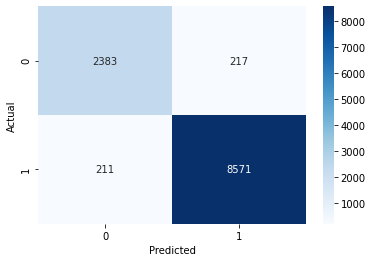

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2600
           1       0.98      0.98      0.98      8782

    accuracy                           0.96     11382
   macro avg       0.95      0.95      0.95     11382
weighted avg       0.96      0.96      0.96     11382

****LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)****


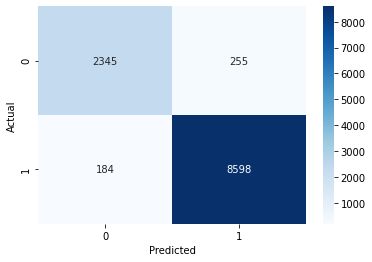

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2600
           1       0.97      0.98      0.98      8782

    accuracy                           0.96     11382
   macro avg       0.95      0.94      0.94     11382
weighted avg       0.96      0.96      0.96     11382



In [ ]:
##Validation2
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

models=[XGBClassifier(),LogisticRegression()]
for i in models:
  print("****{}****".format(i))
  i.fit(x_train,y_train)
  pred=i.predict(x_val2)
  cnf_matrix=confusion_matrix(y_val2,pred)
  sns.heatmap(cnf_matrix,annot=True, fmt='', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  print(classification_report(y_val2,pred))

**Based on the 2 models, what are the essential indicators of unengagement?**


*   Ans: No_of_transaction,	Total_USD, Distinct_Trans_Count




**Compare the performance of the 2 models. Which model should ParTech use?**

*   Both algorithm are performing good  as both are giving f1 score of greater than 90% for both the classes, but I'll choose XGB or LogisticRegression  as LR was inaccurate by 2% in comparison with XGB's recall.



In [ ]:
##Final Model
fmodel=XGBClassifier()
fmodel.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

##Task 4

**Use the model developed in Task 3 to score on 201901 data**

In [ ]:
##Split the data such that
#Scoring data - 201901
scoring=completed_2019.loc[completed_2019['yearmonth']=='2019_1']
scoring=scoring.reset_index()
scoring=scoring.drop(['index','year','yearmonth','user_id'],axis=1)
print(scoring.shape)
scoring.head()

(11020, 4)


,No_of_transaction,Total_USD,Distinct_Trans_Count,Kmeans_Cluster
0,-0.55,-0.13,-0.57,1
1,-0.55,-0.08,-0.57,1
2,1.74,0.00,1.64,0
3,-0.43,-0.05,-0.57,1
4,-0.34,0.06,0.91,1


In [ ]:
x_jan2019=scoring[["No_of_transaction","Total_USD","Distinct_Trans_Count"]]
y_jan2019=scoring['Kmeans_Cluster']

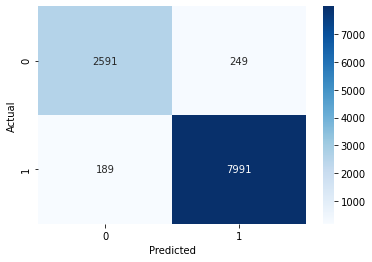

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2840
           1       0.97      0.98      0.97      8180

    accuracy                           0.96     11020
   macro avg       0.95      0.94      0.95     11020
weighted avg       0.96      0.96      0.96     11020



In [ ]:
x_jan2019_pred=fmodel.predict(x_jan2019)
cnf_matrix=confusion_matrix(y_jan2019,x_jan2019_pred)
sns.heatmap(cnf_matrix,annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_jan2019,x_jan2019_pred))

**What can cumulative gains plot tell us about the optimal sample size for testing?**

In [ ]:
!pip install scikit-plot

In [ ]:
res=pd.DataFrame()
res['Actaual']=y_jan2019
res['Predicted']=x_jan2019_pred
res.head()

,Actaual,Predicted
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1


In [ ]:
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(res['Actaual'], res['Predicted'])

plt.show()
